In [ ]:
from sklearn.datasets import load_breast_cancer
cancer = load_breast_cancer()

print(cancer.data.shape)

from sklearn.model_selection import train_test_split
x = cancer.data
y = cancer.target
x_train_all, x_test, y_train_all, y_test = train_test_split(x, y, stratify = y, test_size = 0.2, random_state = 42)
x_train, x_val, y_train, y_val = train_test_split(x_train_all, y_train_all, stratify = y_train_all, test_size = 0.25, random_state = 42)
print(len(x_train), len(x_val), len(x_test))

import numpy as np
train_mean = np.mean(x_train, axis = 0)
train_std = np.std(x_train, axis = 0)



# Normalize training set using train mean and std
X_train = (x_train - train_mean) / train_std

# Normalize validation set using train mean and std
X_val = (x_val - train_mean) / train_std

# Normalize test set using train mean and std
X_test = (x_test - train_mean) / train_std


(569, 30)
341 114 114


# 출력층에서의 오차 (Cross Entropy에서의 Gradient)
dz3 = a3 - yi
dw3 = np.dot(a2.T, dz3) / m + (self.l1 * np.sign(self.w3) + self.l2 * self.w3) / m
db3 = np.sum(dz3) / m

# 두 번째 은닉층에서의 오차
da2 = np.dot(dz3, self.w3.T)
dz2 = da2 * self.a2 * (1 - self.a2)  # sigmoid 함수의 미분 적용
dw2 = np.dot(a1.T, dz2) / m + (self.l1 * np.sign(self.w2) + self.l2 * self.w2) / m
db2 = np.sum(dz2, axis=0) / m

# 첫 번째 은닉층에서의 오차
da1 = np.dot(dz2, self.w2.T)
dz1 = da1 * self.a1 * (1 - self.a1)  # sigmoid 함수의 미분 적용
dw1 = np.dot(x.T, dz1) / m + (self.l1 * np.sign(self.w1) + self.l2 * self.w1) / m
db1 = np.sum(dz1, axis=0) / m

# 가중치와 편향 업데이트
self.w1 -= self.lr * dw1
self.b1 -= self.lr * db1
self.w2 -= self.lr * dw2
self.b2 -= self.lr * db2
self.w3 -= self.lr * dw3
self.b3 -= self.lr * db3


In [ ]:
import numpy as np

class SingleLayerNetwork:

    def __init__(self, hidden_units=10, learning_rate=0.1, l1=0, l2=0):
        self.hidden_units = hidden_units  # 은닉층의 뉴런 개수
        self.w1 = None    # 은닉층 가중치
        self.b1 = None    # 은닉층 절편
        self.w2 = None    # 출력층 가중치
        self.b2 = None    # 출력층 절편
        self.a1 = None    # 은닉층 활성화 값
        self.lr = learning_rate
        self.l1 = l1
        self.l2 = l2
        self.losses = []       # 에포크별 훈련 손실 저장 리스트
        self.val_losses = []   # 에포크별 검증 손실 저장 리스트

    def relu(self, z):
        """ReLU 활성화 함수"""
        return np.maximum(0, z)

    def relu_derivative(self, z):
        """ReLU 활성화 함수의 미분"""
        return np.where(z > 0, 1, 0)

    def forpass(self, x):
        # 은닉층
        z1 = np.dot(x, self.w1) + self.b1
        self.a1 = self.relu(z1)  # ReLU 적용
        # 출력층 (여기서는 sigmoid 사용)
        z2 = np.dot(self.a1, self.w2) + self.b2
        return z2

    def backprop(self, x, err):
        m = len(x)
        # 출력층에 대한 그래디언트
        w2_grad = np.dot(self.a1.T, err) / m
        b2_grad = np.sum(err) / m
        # 은닉층에 대한 그래디언트
        err_hidden = np.dot(err, self.w2.T) * self.relu_derivative(self.a1)
        w1_grad = np.dot(x.T, err_hidden) / m
        b1_grad = np.sum(err_hidden, axis=0) / m
        return w1_grad, b1_grad, w2_grad, b2_grad

    def init_weights(self, n_features):
        # 가중치와 절편 초기화
        self.w1 = np.random.randn(n_features, self.hidden_units) * 0.01
        self.b1 = np.zeros(self.hidden_units)
        self.w2 = np.random.randn(self.hidden_units, 1) * 0.01
        self.b2 = 0

    def fit(self, x, y, epochs=100, x_val=None, y_val=None, patience=10):
        y = y.reshape(-1, 1)
        y_val = y_val.reshape(-1, 1)
        m = len(x)

        # 가중치 초기화
        self.init_weights(x.shape[1])

        # Early stopping을 위한 변수 초기화
        best_val_loss = float('inf')  # 가장 낮은 검증 손실값을 저장할 변수
        patience_counter = 0          # patience 횟수를 세는 변수

        for i in range(epochs):
            a = self.training(x, y, m)
            a = np.clip(a, 1e-10, 1-1e-10)
            loss = np.sum(-(y * np.log(a) + (1 - y) * np.log(1 - a)))
            self.losses.append((loss + self.reg_loss()) / m)  # 훈련 손실 저장
            self.update_val_loss(x_val, y_val)  # 검증 손실 업데이트

            # Early Stopping 검증 로직
            current_val_loss = self.val_losses[-1]  # 현재 검증 손실

            if current_val_loss < best_val_loss:
                best_val_loss = current_val_loss  # 가장 낮은 검증 손실 갱신
                patience_counter = 0  # patience 카운터 초기화
            else:
                patience_counter += 1  # 개선이 없으면 카운터 증가

            if patience_counter >= patience:
                print(f"Early stopping at epoch {i+1}")
                break  # patience 초과 시 학습 중단

    def training(self, x, y, m):
        z = self.forpass(x)
        a = self.activation(z)
        err = -(y - a)
        w1_grad, b1_grad, w2_grad, b2_grad = self.backprop(x, err)
        w1_grad += (self.l1 * np.sign(self.w1) + self.l2 * self.w1) / m
        w2_grad += (self.l1 * np.sign(self.w2) + self.l2 * self.w2) / m
        # 가중치 업데이트
        self.w1 -= self.lr * w1_grad
        self.b1 -= self.lr * b1_grad
        self.w2 -= self.lr * w2_grad
        self.b2 -= self.lr * b2_grad
        return a

    def activation(self, z):
        return 1 / (1 + np.exp(-z))  # 출력층에서는 여전히 sigmoid 사용

    def reg_loss(self):
        return self.l1 * (np.sum(np.abs(self.w1)) + np.sum(np.abs(self.w2))) + \
               self.l2 / 2 * (np.sum(self.w1**2) + np.sum(self.w2**2))

    def update_val_loss(self, x_val, y_val):
        z = self.forpass(x_val)
        a = self.activation(z)
        a = np.clip(a, 1e-10, 1-1e-10)
        val_loss = np.sum(-(y_val * np.log(a) + (1 - y_val) * np.log(1 - a)))
        self.val_losses.append((val_loss + self.reg_loss()) / len(y_val))  # 검증 손실 저장

    ### predict 함수 추가
    def predict(self, X):
        predictions = self.forpass(X)
        return (self.activation(predictions) > 0.5).astype(int)

    ### score 함수 추가
    def score(self, X, y):
        predictions = self.predict(X)
        accuracy = np.mean(predictions == y.reshape(-1, 1))
        return accuracy


In [ ]:
# 모델 학습
model = SingleLayerNetwork(hidden_units=16, learning_rate=0.01, l2=0.01)
model.fit(X_train, y_train, epochs=1000, x_val=X_val, y_val=y_val, patience=10)

# 모델 정확도 확인
accuracy = model.score(X_test, y_test)
print(f"Test set accuracy: {accuracy}")


Test set accuracy: 0.9473684210526315


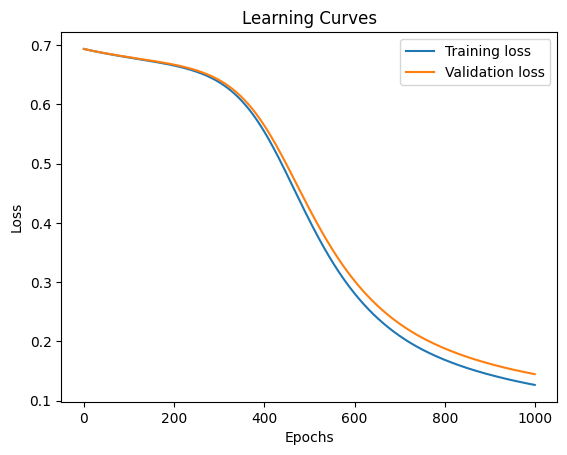

In [ ]:
import matplotlib.pyplot as plt

# 학습 손실과 검증 손실 플롯
plt.plot(model.losses, label='Training loss')
plt.plot(model.val_losses, label='Validation loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()
plt.title('Learning Curves')
plt.show()


## mean loss

In [ ]:
# Test set에서 예측값 계산
predictions = model.forpass(X_test)

# 예측값을 Sigmoid 활성화 함수를 사용해 0~1 사이 값으로 변환
predictions = 1 / (1 + np.exp(-predictions))  # Sigmoid 적용

# Cross-Entropy Loss 계산
y_test_reshaped = y_test.reshape(-1, 1)
epsilon = 1e-10  # 로그 계산 시 overflow 방지용 작은 값
loss = -(y_test_reshaped * np.log(predictions + epsilon) + (1 - y_test_reshaped) * np.log(1 - predictions + epsilon))

# 전체 Test Set에 대한 Mean Loss 계산
mean_loss = np.mean(loss)
print(f"Test set mean loss: {mean_loss}")


Test set mean loss: 0.1466543464686419


### mini batch gradient descent일때

# 출력층에서의 오차 (이 부분은 동일)
dz3 = a3 - yi
dw3 = np.dot(a2.T, dz3) / m + (self.l1 * np.sign(self.w3) + self.l2 * self.w3) / m
db3 = np.sum(dz3) / m

# 두 번째 은닉층에서의 오차 (ReLU 미분 적용)
da2 = np.dot(dz3, self.w3.T)
dz2 = da2 * (self.a2 > 0)  # ReLU 함수의 미분 적용
dw2 = np.dot(a1.T, dz2) / m + (self.l1 * np.sign(self.w2) + self.l2 * self.w2) / m
db2 = np.sum(dz2, axis=0) / m

# 첫 번째 은닉층에서의 오차 (ReLU 미분 적용)
da1 = np.dot(dz2, self.w2.T)
dz1 = da1 * (self.a1 > 0)  # ReLU 함수의 미분 적용
dw1 = np.dot(x.T, dz1) / m + (self.l1 * np.sign(self.w1) + self.l2 * self.w1) / m
db1 = np.sum(dz1, axis=0) / m

# 가중치 업데이트 (이 부분은 동일)
self.w1 -= self.lr * dw1
self.b1 -= self.lr * db1
self.w2 -= self.lr * dw2
self.b2 -= self.lr * db2
self.w3 -= self.lr * dw3
self.b3 -= self.lr * db3


In [ ]:
import numpy as np

class SingleLayerNetwork2:

    def __init__(self, hidden_units=10, learning_rate=0.1, l1=0, l2=0):
        self.hidden_units = hidden_units  # 은닉층의 뉴런 개수
        self.w1 = None    # 은닉층 가중치
        self.b1 = None    # 은닉층 절편
        self.w2 = None    # 출력층 가중치
        self.b2 = None    # 출력층 절편
        self.a1 = None    # 은닉층 활성화 값
        self.lr = learning_rate
        self.l1 = l1
        self.l2 = l2
        self.losses = []       # 에포크별 훈련 손실 저장 리스트
        self.val_losses = []   # 에포크별 검증 손실 저장 리스트

    def relu(self, z):
        """ReLU 활성화 함수"""
        return np.maximum(0, z)

    def relu_derivative(self, z):
        """ReLU 활성화 함수의 미분"""
        return np.where(z > 0, 1, 0)

    def forpass(self, x):
        # 은닉층
        z1 = np.dot(x, self.w1) + self.b1
        self.a1 = self.relu(z1)  # ReLU 적용
        # 출력층 (여기서는 sigmoid 사용)
        z2 = np.dot(self.a1, self.w2) + self.b2
        return z2

    def backprop(self, x, err):
        m = len(x)
        # 출력층에 대한 그래디언트
        w2_grad = np.dot(self.a1.T, err) / m
        b2_grad = np.sum(err) / m
        # 은닉층에 대한 그래디언트
        err_hidden = np.dot(err, self.w2.T) * self.relu_derivative(self.a1)
        w1_grad = np.dot(x.T, err_hidden) / m
        b1_grad = np.sum(err_hidden, axis=0) / m
        return w1_grad, b1_grad, w2_grad, b2_grad

    def init_weights(self, n_features):
        # 가중치와 절편 초기화
        self.w1 = np.random.randn(n_features, self.hidden_units) * 0.01
        self.b1 = np.zeros(self.hidden_units)
        self.w2 = np.random.randn(self.hidden_units, 1) * 0.01
        self.b2 = 0

    def fit(self, x, y, epochs=100, batch_size=32, x_val=None, y_val=None, patience=10):
        y = y.reshape(-1, 1)
        if x_val is not None and y_val is not None:
            y_val = y_val.reshape(-1, 1)

        m = len(x)
        self.init_weights(x.shape[1])  # 가중치 초기화

        best_val_loss = float('inf')  # Early stopping을 위한 최저 검증 손실
        patience_counter = 0  # Early stopping 카운터

        for epoch in range(epochs):
            indices = np.random.permutation(m)  # 데이터를 섞음
            batch_losses = []  # 배치별 손실을 저장할 리스트

            for start_idx in range(0, m, batch_size):
                end_idx = start_idx + batch_size
                xi = x[indices[start_idx:end_idx]]
                yi = y[indices[start_idx:end_idx]]

                # 미니 배치 학습
                a = self.training(xi, yi, batch_size)

                # 손실 계산
                a = np.clip(a, 1e-10, 1-1e-10)  # 예측값을 안정화시킴
                batch_loss = np.sum(-(yi * np.log(a) + (1 - yi) * np.log(1 - a)))  # 배치 손실 계산
                batch_losses.append(batch_loss)

            # 배치별 손실의 평균을 계산
            epoch_loss = np.mean(batch_losses)
            self.losses.append((epoch_loss + self.reg_loss()) / m)

            # 검증 손실 계산 (검증 데이터가 주어졌을 때만)
            if x_val is not None and y_val is not None:
                self.update_val_loss(x_val, y_val)
                current_val_loss = self.val_losses[-1]

                # Early Stopping 로직
                if current_val_loss < best_val_loss:
                    best_val_loss = current_val_loss
                    patience_counter = 0  # 카운터 초기화
                else:
                    patience_counter += 1  # 개선되지 않으면 카운터 증가

                if patience_counter >= patience:
                    print(f"Early stopping at epoch {epoch + 1}")
                    break


    def training(self, x, y, m):
        z = self.forpass(x)
        a = self.activation(z)
        err = -(y - a)
        w1_grad, b1_grad, w2_grad, b2_grad = self.backprop(x, err)
        w1_grad += (self.l1 * np.sign(self.w1) + self.l2 * self.w1) / m
        w2_grad += (self.l1 * np.sign(self.w2) + self.l2 * self.w2) / m
        # 가중치 업데이트
        self.w1 -= self.lr * w1_grad
        self.b1 -= self.lr * b1_grad
        self.w2 -= self.lr * w2_grad
        self.b2 -= self.lr * b2_grad
        return a

    def activation(self, z):
        return 1 / (1 + np.exp(-z))  # 출력층에서는 여전히 sigmoid 사용

    def reg_loss(self):
        return self.l1 * (np.sum(np.abs(self.w1)) + np.sum(np.abs(self.w2))) + \
               self.l2 / 2 * (np.sum(self.w1**2) + np.sum(self.w2**2))

    def update_val_loss(self, x_val, y_val):
        z = self.forpass(x_val)
        a = self.activation(z)
        a = np.clip(a, 1e-10, 1-1e-10)
        val_loss = np.sum(-(y_val * np.log(a) + (1 - y_val) * np.log(1 - a)))
        self.val_losses.append((val_loss + self.reg_loss()) / len(y_val))  # 검증 손실 저장

    ### predict 함수 추가
    def predict(self, X):
        predictions = self.forpass(X)
        return (self.activation(predictions) > 0.5).astype(int)

    ### score 함수 추가
    def score(self, X, y):
        predictions = self.predict(X)
        accuracy = np.mean(predictions == y.reshape(-1, 1))
        return accuracy


In [ ]:
# 모델 학습
# 예시
model2 = SingleLayerNetwork2(hidden_units=16, learning_rate=0.01, l2=0.01)
model2.fit(X_train, y_train, epochs=100000, batch_size=32, x_val=X_val, y_val= y_val, patience=10)


# 모델 정확도 확인
accuracy = model2.score(X_test, y_test)
print(f"Test set accuracy: {accuracy}")

Early stopping at epoch 608
Test set accuracy: 0.9649122807017544


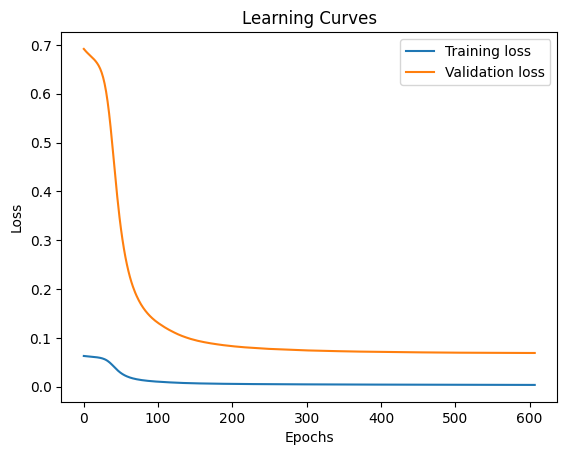

In [ ]:
import matplotlib.pyplot as plt

# 학습 손실과 검증 손실 플롯
plt.plot(model2.losses, label='Training loss')
plt.plot(model2.val_losses, label='Validation loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()
plt.title('Learning Curves')
plt.show()


### stohastic 1 hidden layer

# 출력층에서의 오차
dz2 = a2 - yi  # Cross Entropy에서의 Gradient
dw2 = np.dot(a1.T, dz2) / m + (self.l2 * self.w2) / m  # L2 규제 포함
db2 = np.sum(dz2) / m

# 은닉층에서의 오차 (ReLU 미분 적용)
da1 = np.dot(dz2, self.w2.T)
dz1 = da1 * (self.a1 > 0)  # ReLU 함수의 미분 적용
dw1 = np.dot(x.T, dz1) / m + (self.l2 * self.w1) / m  # L2 규제 포함
db1 = np.sum(dz1, axis=0) / m

# 가중치 업데이트
self.w1 -= self.lr * dw1
self.b1 -= self.lr * db1
self.w2 -= self.lr * dw2
self.b2 -= self.lr * db2


In [ ]:
import numpy as np

class SingleLayerNetwork3:

    def __init__(self, hidden_units=10, learning_rate=0.1, l2=0.01):
        self.hidden_units = hidden_units  # 은닉층의 뉴런 개수
        self.lr = learning_rate           # 학습률
        self.l2 = l2                      # L2 규제 항
        self.losses = []                  # 에포크별 훈련 손실 저장 리스트
        self.val_losses = []              # 에포크별 검증 손실 저장 리스트

    def relu(self, z):
        """ReLU 활성화 함수"""
        return np.maximum(0, z)

    def relu_derivative(self, z):
        """ReLU 활성화 함수의 미분"""
        return np.where(z > 0, 1, 0)

    def sigmoid(self, z):
        """Sigmoid 활성화 함수 (출력층에 사용)"""
        return 1 / (1 + np.exp(-z))

    def init_weights(self, n_features):
        """가중치와 편향 초기화"""
        self.w1 = np.random.randn(n_features, self.hidden_units) * 0.01
        self.b1 = np.zeros(self.hidden_units)
        self.w2 = np.random.randn(self.hidden_units, 1) * 0.01
        self.b2 = 0

    def forpass(self, x):
        """순전파"""
        # 은닉층
        z1 = np.dot(x, self.w1) + self.b1
        a1 = self.relu(z1)
        # 출력층
        z2 = np.dot(a1, self.w2) + self.b2
        return z2, a1

    def backprop(self, x, y, a1, z2):
        """역전파"""
        m = len(x)
        # 출력층 오차
        error_output = -(y - self.sigmoid(z2))
        # 은닉층 오차
        error_hidden = np.dot(error_output, self.w2.T) * self.relu_derivative(a1)
        # 가중치와 편향의 그래디언트 계산
        w2_grad = np.dot(a1.T, error_output) / m + (self.l2 * self.w2) / m  # L2 규제 포함
        b2_grad = np.sum(error_output) / m
        w1_grad = np.dot(x.T, error_hidden) / m + (self.l2 * self.w1) / m  # L2 규제 포함
        b1_grad = np.sum(error_hidden, axis=0) / m
        return w1_grad, b1_grad, w2_grad, b2_grad

    def fit(self, x, y, epochs=100, x_val=None, y_val=None):
        """모델 학습 (Stochastic Gradient Descent)"""
        y = y.reshape(-1, 1)  # y를 (n, 1)로 변환
        if x_val is not None and y_val is not None:
            y_val = y_val.reshape(-1, 1)

        m = len(x)
        self.init_weights(x.shape[1])  # 가중치 초기화

        for epoch in range(epochs):
            total_loss = 0  # 배치별 손실을 모두 더할 변수
            indices = np.random.permutation(m)  # 데이터를 섞음

            # 각 배치별 손실을 따로 기록
            batch_losses = []  # 배치별 훈련 손실 저장 리스트

            for idx in indices:
                xi = x[idx:idx+1]  # 하나의 데이터 포인트
                yi = y[idx:idx+1]  # 해당 데이터 포인트의 레이블

                # 순전파
                z2, a1 = self.forpass(xi)

                # 역전파
                w1_grad, b1_grad, w2_grad, b2_grad = self.backprop(xi, yi, a1, z2)

                # 가중치와 편향 업데이트
                self.w1 -= self.lr * w1_grad
                self.b1 -= self.lr * b1_grad
                self.w2 -= self.lr * w2_grad
                self.b2 -= self.lr * b2_grad

                # 배치 손실 계산
                batch_loss = self.compute_loss(xi, yi)
                batch_losses.append(batch_loss)  # 배치별 손실 기록

            # 배치별 손실의 평균을 저장
            total_loss = np.mean(batch_losses)
            self.losses.append(total_loss)

            # 검증 손실 계산 (검증 데이터가 주어진 경우에만)
            if x_val is not None and y_val is not None:
                val_loss = self.compute_loss(x_val, y_val)
                self.val_losses.append(val_loss)




    def compute_loss(self, x, y):
        """손실 함수 계산 (Cross Entropy Loss + L2 규제)"""
        z2, _ = self.forpass(x)
        a2 = self.sigmoid(z2)
        a2 = np.clip(a2, 1e-10, 1 - 1e-10)  # 안정화
        cross_entropy_loss = -np.mean(y * np.log(a2) + (1 - y) * np.log(1 - a2))
        l2_loss = (self.l2 / 2) * (np.sum(self.w1**2) + np.sum(self.w2**2))  # L2 규제 항
        return cross_entropy_loss + l2_loss

    def predict(self, x):
        """모델 예측"""
        z2, _ = self.forpass(x)
        return (self.sigmoid(z2) > 0.5).astype(int)

    def score(self, x, y):
        """모델 정확도 계산"""
        predictions = self.predict(x)
        accuracy = np.mean(predictions == y.reshape(-1, 1))
        return accuracy




In [ ]:
model3 = SingleLayerNetwork3(hidden_units=16, learning_rate=0.01, l2=0.01)
model3.fit(X_train, y_train, epochs=100, x_val=X_val, y_val=y_val)
# 모델 정확도 확인
accuracy = model3.score(X_test, y_test)
print(f"Test set accuracy: {accuracy}")


Test set accuracy: 0.9824561403508771


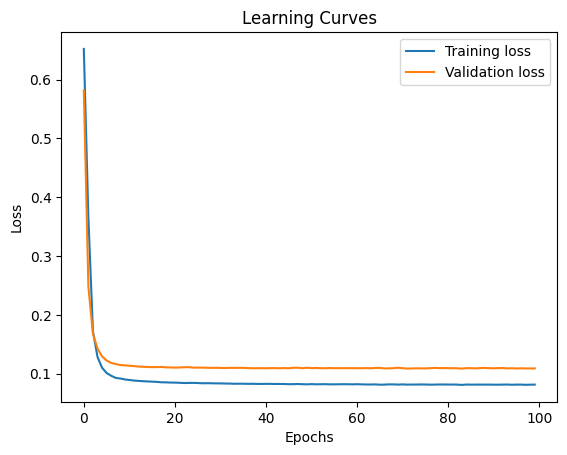

In [ ]:
import matplotlib.pyplot as plt

# 학습 손실과 검증 손실 플롯
plt.plot(model3.losses, label='Training loss')
plt.plot(model3.val_losses, label='Validation loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()
plt.title('Learning Curves')
plt.show()

### mean loss 구하는법

In [ ]:
# 학습 완료 후 테스트 데이터로 손실을 계산하는 방법
# 예시에서는 SingleLayerNetwork 객체가 이미 학습된 상태라고 가정합니다.

# 1. 순전파를 통해 예측값 구하기
z_test = network.forpass(x_test)  # x_test에 대해 순전파(forward pass)
a_test = network.activation(z_test)  # 활성화 함수(sigmoid) 적용

# 2. 안정적인 로그 계산을 위해 예측값 클리핑
a_test = np.clip(a_test, 1e-10, 1 - 1e-10)

# 3. Cross Entropy Loss 계산
test_loss = np.sum(-(y_test * np.log(a_test) + (1 - y_test) * np.log(1 - a_test)))

# 4. L2 규제 손실 포함하여 총 손실 계산
l2_loss = (network.l2 / 2) * (np.sum(network.w1**2) + np.sum(network.w2**2))

# 5. 평균 손실 계산
mean_loss = (test_loss + l2_loss) / len(y_test)

# 결과 출력
print(f"Test set mean loss: {mean_loss}")
